# spinal_test2.ipynb
Second test of the delegational learning rule in the context of the spinal cord project.
The task is the same as in spinal_test1.ipynb, but the am_pm_oscillator model is used.

Let $S_F, S_P, S_{P-F}, M_C$ denote the regions of the cortical model, and $s_F, s_P, s_{P-F}, m_C$ denote their current activities.
Assume that each unit $u_j$ in $M_C$ is associated with a vector $\bar{v}_j$, and that the ouput of the plant is $p = \sum_j u_j \bar{v}_j$. We also set $s_F = p$. The rule should be such that $p \approx s_P$.

The plant $P$ can be implemented as a population of linear units.
If the connection matrix from $M_C$ to $P$ is called $W$, then
$\bar{v}_j = (W_{1,j}, W_{2,j}, ..., W_{n,j})^T \equiv W_{:,j}$. 

# PART 1
Open loop test of the `am_pm_oscillator` model.

In [1]:
%cd ../..
from draculab import *
import numpy as np
import matplotlib.pyplot as plt
import time

/home/z/projects/draculab


In [2]:
net_params = {'min_delay' : 0.01,
              'min_buff_size' : 10 }
osc_params = {'type' : unit_types.am_pm_oscillator,
            'integ_meth' : 'odeint',
            'tau_u' : 1.,
            'tau_c' : 1.,
            'tau_t' : 1.,
            'tau_s' : 0.02,
            'init_val' : [[0.2, 0.2, 0., 0.1], [0.5, 0.5, 0., 0.8]],
            'multidim' : True,
            'omega' : 1.,
            'F' : 'zero',
            'tau_fast': 0.1,
            'tau_mid' : 0.4,
            'tau_slow' : 2.,
            'delay' : 0.11,
            'mu' : 0.,
            'sigma' : 0.0 }
src_params = {'type' : unit_types.source,
              'init_val' : 1.,
              'function' : lambda t: np.sin(10.*t) }
net = network(net_params)
osc = net.create(2, osc_params)
src = net.create(1, src_params)
src__osc_conn = {'rule' : "all_to_all",
                 'delay' : 0.02 }
src__osc_syn = {'type' : synapse_types.static,
                'inp_ports': 0,
                'init_w' : 1. }
net.connect(src, osc, src__osc_conn, src__osc_syn)

In [3]:
start_time = time.time()
#times, data, _  = net.flat_run(10.)
times, data, _  = net.run(10.)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)

Execution time is 0.5331940650939941 seconds


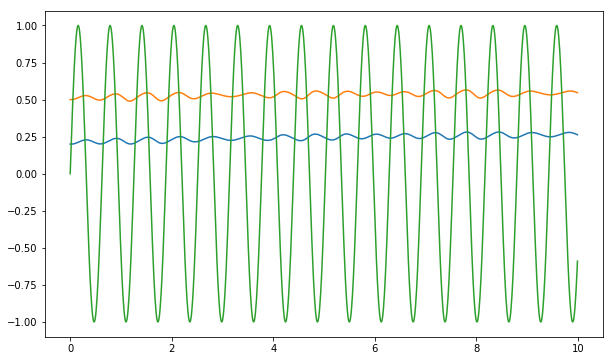

In [4]:
fig = plt.figure(figsize=(10,6))
plt.plot(times, data.transpose())
#plt.plot(times, np.sqrt(2.)*np.sin(2.*times), 'r')
plt.show()

# PART 2
Closed loop test of the `am_pm_oscillator` model for a single-dimensional plant.

In [1]:
%cd ../..
from draculab import *
import numpy as np
import matplotlib.pyplot as plt
import time

/home/z/projects/draculab


In [2]:
# Create the neuronal populations
des_val = 0.2 # desired value in SP
des_vals = np.random.random(2000) # list of desired values

# PARAMETER DICTIONARIES
net_params = {'min_delay' : 0.001,
              'min_buff_size' : 10 }
SF_params = {'type' : unit_types.sigmoidal,
             'thresh' : 0.,
             'slope' : 1.,
             'init_val' : 0.2,
             'tau' : 0.05 }
SP_params = {'type' : unit_types.source,
             'init_val' : des_val,
             'function' : lambda t: des_vals[int(round(t/10.))] }
SPF1_params = {'type' : unit_types.out_norm_sig,
              'thresh' : 0.5,
              'slope' : 4.,
              'delay' : 0.32,
              'init_val' : 0.3,
              'tau_fast': 0.005,
              'tau_mid': 0.05,
              'tau_slow' : 5.,
              'tau' : 0.05,
              'des_out_w_abs_sum' : 1. }
SPF2_params = SPF1_params
P_params = {'type' : unit_types.linear,
            'init_val' : 0.,
            'tau' : 0.05 }
#init_base = np.array([0.5, 0.5, 0.5, 2.*np.pi, 0.5])
init_base = np.array([0.5, 0.5, 2.*np.pi, 0.5])
M_params = {'type' : unit_types.am_pm_oscillator,
            'integ_meth' : 'euler_maru',
            'tau_u' : 0.1,
            'tau_c' : .2,
            'tau_t' : 1.,
            'tau_s' : 0.01,
            'init_val' :  np.random.random()*init_base,
            'multidim' : True,
            'omega' : 2.*np.pi,
            'F' : 'zero', #'input_sum',
            'tau_fast': 0.005,
            'tau_mid' : 0.05,
            'tau_slow' : 1.,
            'custom_inp_del' : 230,
            'delay' : 0.32,
            'mu' : 0.,
            'sigma' : 0.01 }
track_params = {'type' : unit_types.source,
                'init_val' : 0.02,
                'function' : lambda t: None }

# calculate delay for learning rule
w = M_params['omega'] / M_params['tau_t'] # angular frequency
mp_del = np.arctan(P_params['tau']*w)/w
psf_del = np.arctan(SF_params['tau']*w)/w
sfspf_del = np.arctan(SPF1_params['tau']*w)/w
spfm_del1 = np.arctan(M_params['tau_c']*w)/w
spfm_del2 = np.arctan(M_params['tau_u']*w)/w
d1 = mp_del + psf_del + sfspf_del + 4.*0.02
del_steps = int(np.ceil(d1/net_params['min_delay']))
M_params['custom_inp_del'] = del_steps

# CREATING UNITS
net = network(net_params)
SF = net.create(1, SF_params)
SP = net.create(1, SP_params)
SPF1 = net.create(1, SPF1_params)
SPF2 = net.create(1, SPF2_params)
P = net.create(1, P_params)
ME = net.create(1, M_params)
M_params['init_val'] = np.random.random()*init_base,
MI = net.create(1, M_params)

SPF_M_track = net.create(4, track_params) # to track synaptic weights
spf_diff_track = net.create(4, track_params) # to track SPF derivatives used in M
ME_I0_track = net.create(1, track_params) # to track the 4th state variable of M (I0)
xp_track = net.create(1, track_params) # del_avg_inp_deriv of ME at port 1
up_track = net.create(1, track_params) # to track the derivative of ME
sp_track = net.create(1, track_params) # avg_inp_deriv_mp for ME at port 1
spj_track = net.create(1, track_params) # input derivative for SPF1--ME
dc_track = net.create(2, track_params) # DC component of M units

# CONNECTION DICTIONARIES
SF__SPF1_conn = {'rule' : "one_to_one",
                 'delay' : 0.02 }
SF__SPF2_conn = SF__SPF1_conn
SF__SPF1_syn = {'type' : synapse_types.static,
               'init_w' : -1. }
SF__SPF2_syn = {'type' : synapse_types.static,
               'init_w' : 1. }
SP__SPF1_conn = {'rule' : "one_to_one",
                'delay' : 0.02 }
SP__SPF2_conn = SP__SPF1_conn
SP__SPF1_syn = {'type' : synapse_types.static,
               'init_w' : 1. }
SP__SPF2_syn = {'type' : synapse_types.static,
               'init_w' : -1. }
SPF1__ME_conn = {'rule': 'all_to_all',
                'delay': 0.02 }
SPF2__ME_conn = SPF1__ME_conn
SPF1__MI_conn = SPF1__ME_conn
SPF2__MI_conn = SPF1__ME_conn
SPF1__ME_syn = {#'type' : synapse_types.diff_hebbsnorm,
                #'type' : synapse_types.diff_hebbsnorm2,
                'type' : synapse_types.rga,
                'lrate': 50.,
                'post_delay': del_steps,
                'inp_ports': 0,
                'max_w' : 1.,
                'min_w' : 0.,
                'init_w' : {'distribution':'uniform', 'low':0.05, 'high':.1} }
SPF2__ME_syn = SPF1__ME_syn
SPF1__MI_syn = SPF1__ME_syn
SPF2__MI_syn = SPF1__ME_syn
# Specify the connections from ME/MI to P
ME__P_conn = {'rule': 'all_to_all',
              'delay': 0.02 }
ME__P_syn = {'type': synapse_types.static,
             'init_w' : 1.5 }
MI__P_conn = ME__P_conn
MI__P_syn = {'type': synapse_types.static,
             'init_w' : -1.5 }
# From P to SF
P__SF_conn = {'rule' : 'one_to_one',
              'delay' : 0.02 }
P__SF_syn = {'type' : synapse_types.static,
             'init_w' : 3. }
# lateral connections in M
ME__MI_conn = {'rule': 'one_to_one',
               'allow_autapses' : False,
               'delay' : 0.02 }
ME__MI_syn = {'type' : synapse_types.static,
              'lrate' : 0.1,
              'inp_ports': 1,
              'init_w' : -0.5 }
MI__ME_conn = ME__MI_conn
MI__ME_syn = ME__MI_syn

# CONNECTING
net.connect(SF, SPF1, SF__SPF1_conn, SF__SPF1_syn)
net.connect(SF, SPF2, SF__SPF2_conn, SF__SPF2_syn)
net.connect(SP, SPF1, SP__SPF1_conn, SP__SPF1_syn)
net.connect(SP, SPF2, SP__SPF2_conn, SP__SPF2_syn)
net.connect(SPF1, ME, SPF1__ME_conn, SPF1__ME_syn)
net.connect(SPF1, MI, SPF1__MI_conn, SPF1__MI_syn)
net.connect(SPF2, ME, SPF2__ME_conn, SPF2__ME_syn)
net.connect(SPF2, MI, SPF2__MI_conn, SPF2__MI_syn)
net.connect(ME, P, ME__P_conn, ME__P_syn)
net.connect(MI, P, MI__P_conn, MI__P_syn)
net.connect(P, SF, P__SF_conn, P__SF_syn)
net.connect(ME, MI, ME__MI_conn, ME__MI_syn)
net.connect(MI, ME, MI__ME_conn, MI__ME_syn)

# SETTING UP WEIGHT TRACKING
# This is dependent on the order in which net.connect is called above
net.units[SPF_M_track[0]].set_function(lambda t: net.syns[ME[0]][0].w) # SPF1--ME
net.units[SPF_M_track[1]].set_function(lambda t: net.syns[ME[0]][1].w) # SPF2--ME
net.units[SPF_M_track[2]].set_function(lambda t: net.syns[MI[0]][0].w) # SPF1--MI
net.units[SPF_M_track[3]].set_function(lambda t: net.syns[MI[0]][1].w) # SPF2--MI

# SETTING UP DERIVATIVE TRACKING
net.units[spf_diff_track[0]].set_function(lambda t: net.units[ME[0]].inp_deriv_mp[0][0]) # SPF1 diff
net.units[spf_diff_track[1]].set_function(lambda t: net.units[ME[0]].inp_deriv_mp[0][1]) # SPF2 diff
net.units[spf_diff_track[2]].set_function(lambda t: net.units[ME[0]].del_inp_deriv_mp[0][0]) # SPF1 diff delayed
net.units[spf_diff_track[3]].set_function(lambda t: net.units[ME[0]].del_inp_deriv_mp[0][1]) # SPF2 diff delayed

# SETTING TRACKING OF PLASTICITY FACTORS
net.units[xp_track[0]].set_function(lambda t: net.units[ME[0]].del_avg_inp_deriv_mp[1])
po_de = SPF1__ME_syn['post_delay']
net.units[up_track[0]].set_function(lambda t: net.units[ME[0]].get_lpf_fast(po_de) - 
                                    net.units[ME[0]].get_lpf_mid(po_de))
net.units[sp_track[0]].set_function(lambda t: net.units[ME[0]].avg_inp_deriv_mp[0])
ds = net.syns[ME[0]][0].delay_steps
net.units[spj_track[0]].set_function(lambda t: net.units[SPF1[0]].get_lpf_fast(ds) - 
                                     net.units[SPF1[0]].get_lpf_mid(ds))

# SETTING UP TRACKING OF ME STATE VARIABLES
net.units[dc_track[0]].set_function(lambda t: net.units[ME[0]].buffer[1, -1])
net.units[dc_track[1]].set_function(lambda t: net.units[MI[0]].buffer[1, -1])
net.units[ME_I0_track[0]].set_function(lambda t: net.units[ME[0]].buffer[3][-1])

In [10]:
start_time = time.time()
times, data, _  = net.flat_run(400.)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)

/home/z/projects/draculab/units/spinal_units.py:193: RuntimeWarning: overflow encountered in double_scalars
  Du = ((1.-y[0]) * y[0] * (Dc + (y[1] - y[0]) +
/home/z/projects/draculab/units/units.py:593: RuntimeWarning: invalid value encountered in double_scalars
  return self.act_buff[base] + frac2 * ( self.act_buff[base+1] - self.act_buff[base] )
/home/z/projects/draculab/units/spinal_units.py:187: RuntimeWarning: overflow encountered in double_scalars
  Dc = (I[0] * (1. - y[1]) + I[1]*y[1]) / self.tau_c
/home/z/projects/draculab/units/units.py:1428: RuntimeWarning: invalid value encountered in double_scalars
  return ( self.inp_sum[s] - y ) * self.rtau
/home/z/projects/draculab/units/spinal_units.py:187: RuntimeWarning: invalid value encountered in double_scalars
  Dc = (I[0] * (1. - y[1]) + I[1]*y[1]) / self.tau_c


Execution time is 381.4247794151306 seconds


In [11]:
uid = SPF2[0]
unit = net.units[uid]
w_sum = 0.
for list_idx, syn_list in enumerate(net.syns):
    for syn_idx, syn in enumerate(syn_list):
        if syn.preID == uid:
            w_sum += abs(syn.w)
w_sum

nan

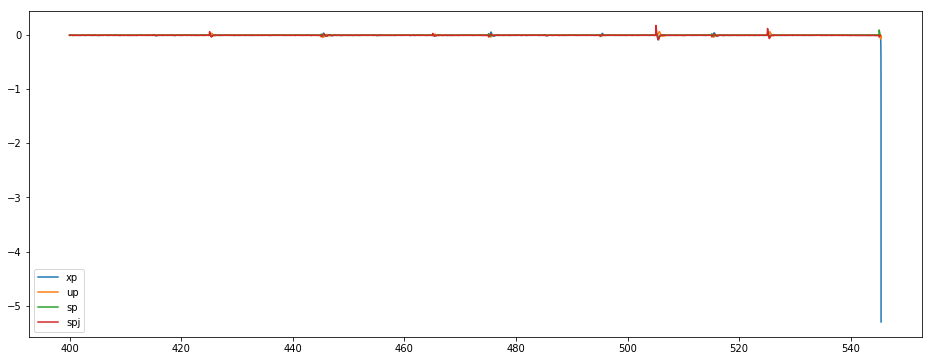

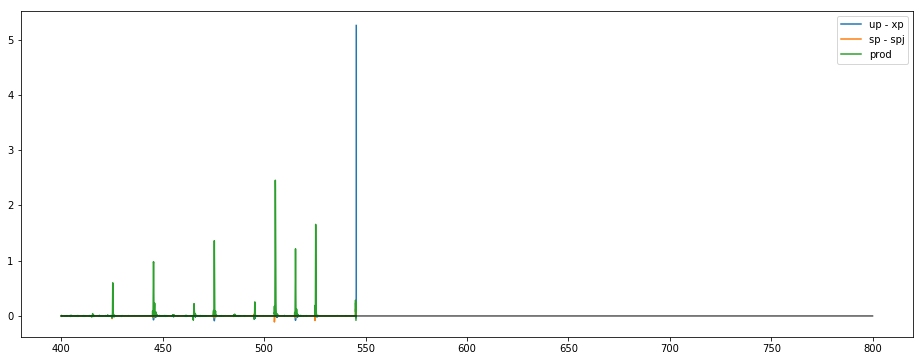

In [12]:
# plot all factors in the SPF1--ME synaptic plasticity
fs = (16,6)
platic_fig = plt.figure(figsize=fs)
xp_data = np.array(data[xp_track[0]])
up_data = np.array(data[up_track[0]])
sp_data = np.array(data[sp_track[0]])
spj_data = np.array(data[spj_track[0]])
plt.plot(times, xp_data)
plt.plot(times, up_data)
plt.plot(times, sp_data)
plt.plot(times, spj_data)
plt.legend(['xp', 'up', 'sp', 'spj'])

platic_fig2 = plt.figure(figsize=fs)
f1 = up_data - xp_data
f2 = sp_data - spj_data
rule = 500. * f1 * f2
plt.plot(times, f1)
plt.plot(times, f2)
plt.plot(times, rule)
plt.plot(times, np.zeros(len(times)), 'k', linewidth=1)
plt.legend(['up - xp', 'sp - spj', 'prod'])
plt.show()

In [6]:
net.units[ME[0]].buffer[:,0]

array([1.33105583e-01, 1.17808882e-01, 2.51245976e+03, 1.20975602e-02])

[nan nan]
[nan]
[nan]


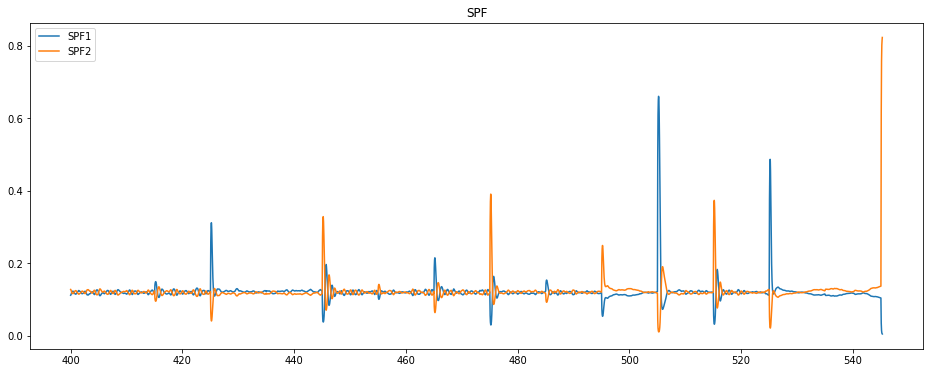

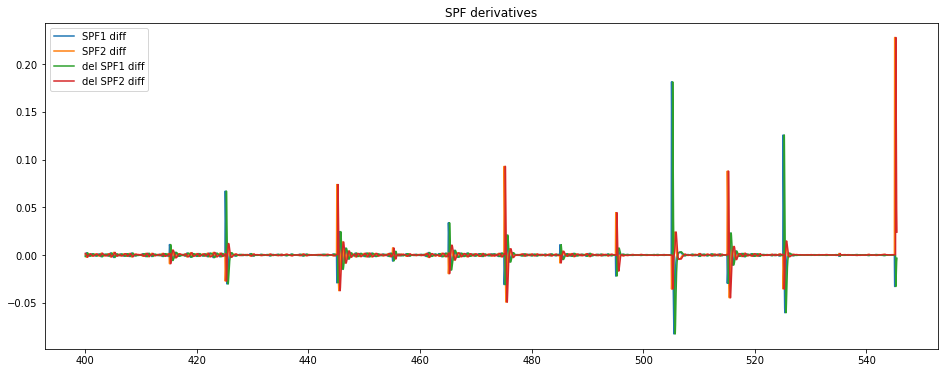

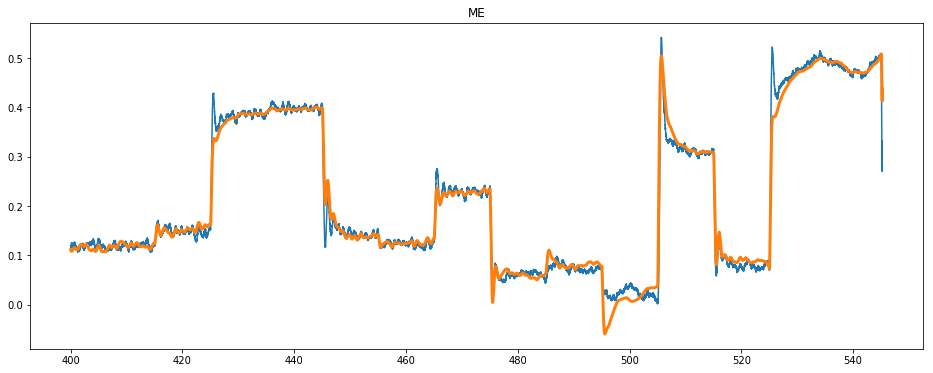

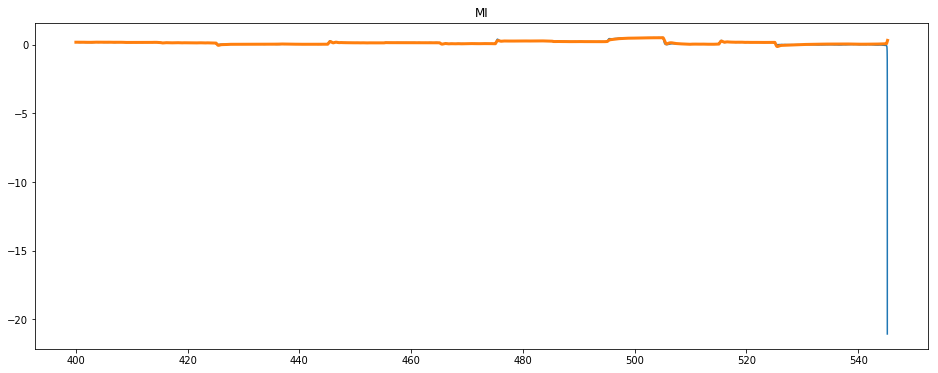

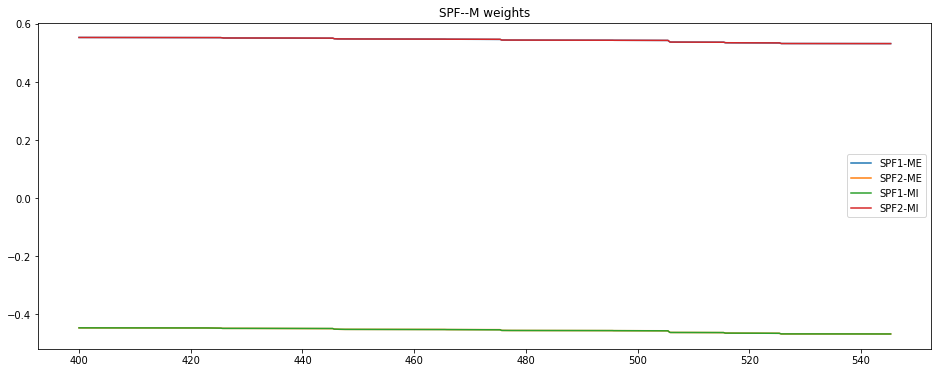

In [13]:
# SPF
fs = (16,6)
SPF_fig = plt.figure(figsize=fs)
SPF_data = np.array(data[SPF1+SPF2])
plt.plot(times, SPF_data.transpose())
plt.legend(['SPF1', 'SPF2'])
plt.title('SPF')
print(SPF_data[:,-1])

# SPF inputs derivatives
#"""
diff_fig = plt.figure(figsize=fs)
spf_diff_track_data = np.array(data[spf_diff_track])
plt.plot(times, spf_diff_track_data.transpose())
plt.legend(['SPF1 diff', 'SPF2 diff', 'del SPF1 diff', 'del SPF2 diff'])
plt.title('SPF derivatives')
#"""
# ME
ME_fig = plt.figure(figsize=fs)
ME_data = np.array(data[ME])
plt.plot(times, ME_data.transpose())
plt.plot(times, data[dc_track[0]], linewidth=3)
plt.title('ME')
print(ME_data[:,-1])

# MI
MI_fig = plt.figure(figsize=fs)
MI_data = np.array(data[MI])
plt.plot(times, MI_data.transpose())
plt.plot(times, data[dc_track[1]], linewidth=3)
plt.title('MI')
print(MI_data[:,-1])

# SPF--M weights
W_fig = plt.figure(figsize=fs)
w_track_data = np.array(data[SPF_M_track])
plt.plot(times, w_track_data.transpose())
plt.legend(['SPF1-ME', 'SPF2-ME', 'SPF1-MI', 'SPF2-MI'])
plt.title('SPF--M weights')

plt.show()

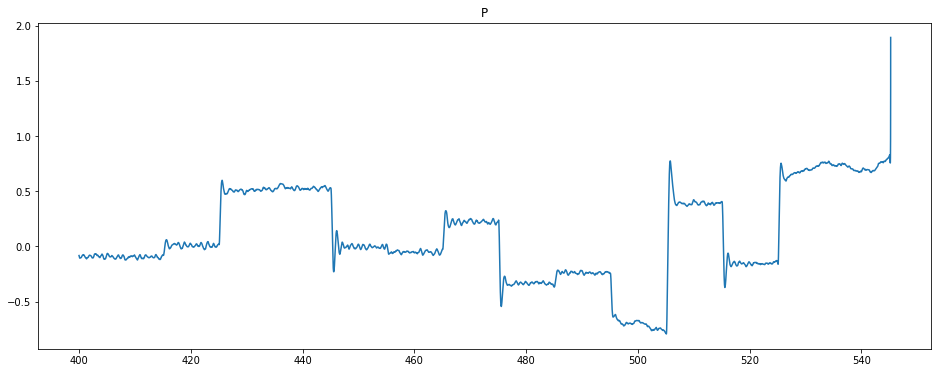

[nan]


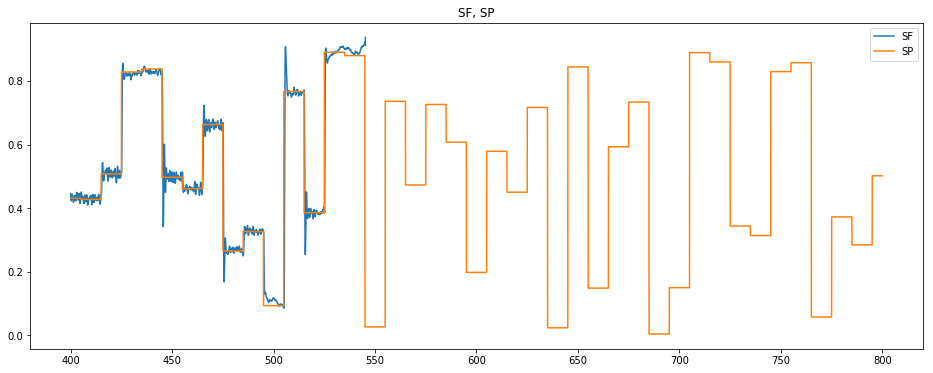

SF = nan
SP = 0.501685


In [14]:
# P
P_fig = plt.figure(figsize=(16,6))
P_data = np.array(data[P])
plt.plot(times, P_data.transpose())
plt.title('P')
plt.show()
print(P_data[:,-1])

# SF, SP
SF_fig = plt.figure(figsize=(16,6))
SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
plt.plot(times, SF_data.transpose(), label='SF')
plt.plot(times, SP_data.transpose(), label='SP')
plt.legend()
plt.title('SF, SP')
plt.show()
print('SF = %f' % (SF_data[:,-1]))
print('SP = %f' % (SP_data[:,-1]))

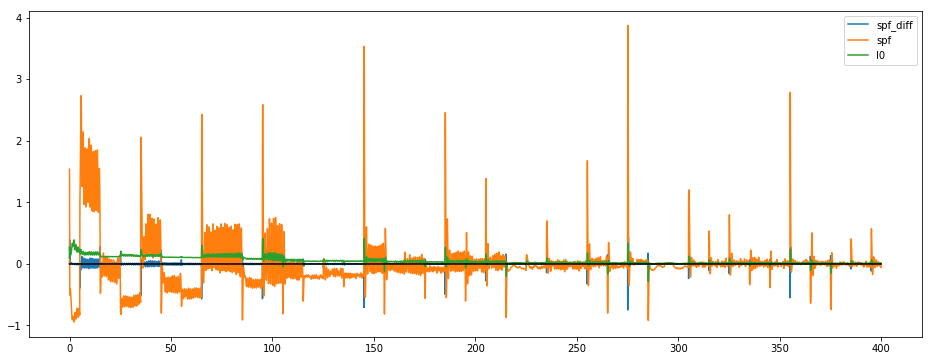

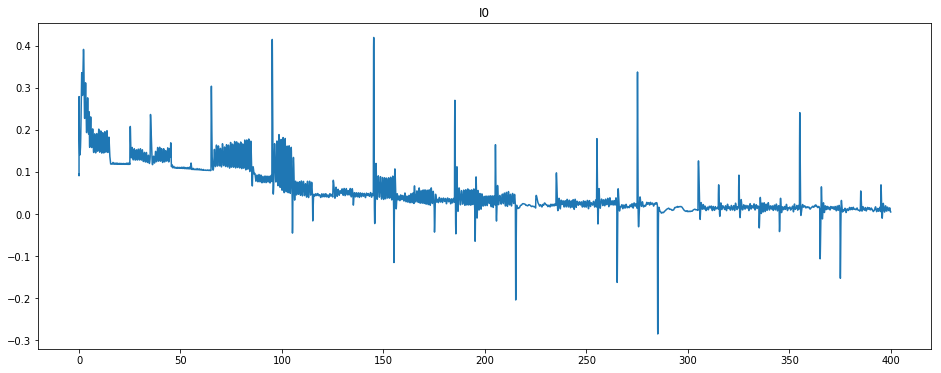

In [9]:
# Compare SPF with its putative derivative
diff_view_fig = plt.figure(figsize=fs)
diff_mean = np.mean(spf_diff_track_data[0,:])
SPF_diff_norm = (spf_diff_track_data[0,:]- diff_mean)/ (10000.*diff_mean)
spf_mean = np.mean(SPF_data[0,:])
SPF_norm = (SPF_data[0,:] - spf_mean) / spf_mean
I0 = data[ME_I0_track[0]]
plt.plot(times, SPF_diff_norm)
plt.plot(times, SPF_norm)
plt.plot(times, I0)
plt.plot(times, np.zeros(len(times)), 'k')
plt.legend(['spf_diff', 'spf', 'I0'])

I0_fig = plt.figure(figsize=fs)
plt.plot(times, I0)
plt.title('I0')
plt.show()


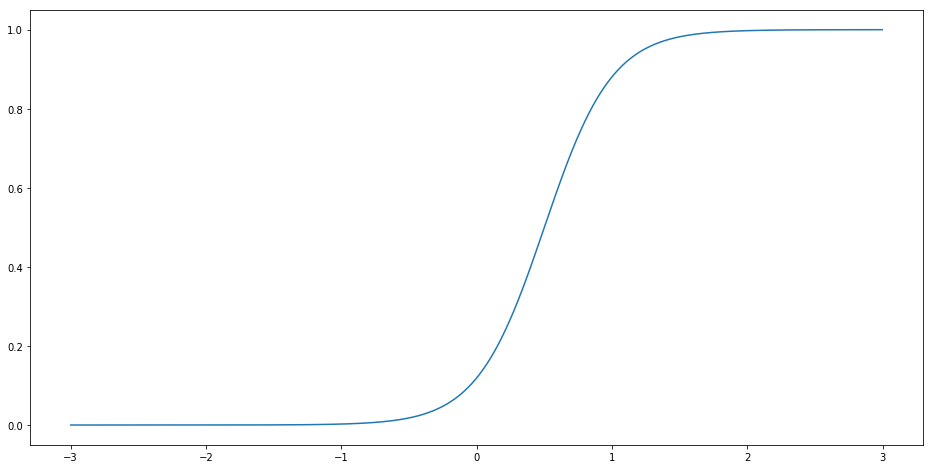

In [44]:
slope = 4.
thresh = 0.5
f = lambda x : 1. / (1. + np.exp(-slope*(x - thresh)))
fig = plt.figure(figsize=(16,8))
x = np.arange(-3.,3,0.003)
fx = f(x)
plt.plot(x, fx)
plt.show()

# PART 3
Closed loop test of the `am_pm_oscillator` model for a multidimensional plant.

In [1]:
%cd ../..
from draculab import *
import numpy as np
import matplotlib.pyplot as plt
import time

/home/z/projects/draculab


In [2]:
# Create the neuronal populations
N = 2 # size of each population
des_pat = np.zeros(N) # desired pattern in SP
des_pats = np.random.random((2000, N)) # many desired patterns for SP

des_pat[np.arange(0,N,2)] = .9 # a 'one' every other entry



net_params = {'min_delay' : 0.001,
              'min_buff_size' : 10 }
SF_params = {'type' : unit_types.sigmoidal,
             'thresh' : 0.,
             'slope' : 1.,
             'init_val' : 0.2,
             'tau' : 0.05 }
SP_params = {'type' : unit_types.source,
             'init_val' : 0.5,
             'function' : lambda x: None }
SPF1_params = {'type' : unit_types.sigmoidal,
              'thresh' : 0.5,
              'slope' : 4.,
              'delay' : 0.3,
              'init_val' : 0.3,
              'tau_fast': 0.005,
              'tau_mid': 0.05,
              'tau_slow' : 5.,
              'tau' : 0.05 }
SPF2_params = SPF1_params
P_params = {'type' : unit_types.linear,
            'init_val' : 0.,
            'tau' : 0.05 }
init_base = np.array([0.5, 0.5, 2.*np.pi, 0.5])
M_params = {'type' : unit_types.am_pm_oscillator,
            'tau_u' : 0.1,
            'tau_c' : .3,
            'tau_t' : 1.,
            'tau_s' : 0.01,
            'init_val' : [r*init_base for r in np.random.random(N)],
            'multidim' : True,
            'omega' : 2.*np.pi,
            'F' : 'input_sum',
            'custom_inp_del' : 300,
            'tau_fast': 0.005,
            'tau_mid' : 0.05,
            'tau_slow' : 1.,
            'delay' : 0.32 }

def create_freqs_steps(n, w, r):
    """ Returns a 2-tuple with the lists required for heterogeneous frequencies.
    
        Args:
            n : number of units
            w : base angular (rad/s)
            r : amplitude of noise
        Returns
            2-tuple : (freqs, steps)
            freqs : a list with n angular frequencies.
            steps : a list with the corresponding delays. 
    """
    ws = w + r*(np.random.random(N) - 0.5)
    ws = ws / M_params['tau_t'] # angular frequencies
    mp_del = np.arctan(P_params['tau']*ws)/ws
    psf_del = np.arctan(SF_params['tau']*ws)/ws
    sfspf_del = np.arctan(SPF1_params['tau']*ws)/ws
    spfm_del1 = np.arctan(M_params['tau_c']*ws)/ws
    spfm_del2 = np.arctan(M_params['tau_u']*ws)/ws
    d1 = mp_del + psf_del + sfspf_del + 4.*0.02
    del_steps = [int(d) for d in np.ceil(d1/net_params['min_delay'])]
    return (list(ws), del_steps)

om_var = 2. # increases frequency heterogeneity

# creating units
net = network(net_params)
SF = net.create(N, SF_params)
SP = net.create(N, SP_params)
SPF1 = net.create(N, SPF1_params)
SPF2 = net.create(N, SPF2_params)
P = net.create(N, P_params)

omegasE, del_stepsE = create_freqs_steps(N, M_params['omega'], om_var)
M_params['omega'] = omegasE
M_params['custom_inp_del'] = del_stepsE
ME = net.create(N, M_params)

omegasI, del_stepsI = create_freqs_steps(N, M_params['omega'], om_var)
M_params['omega'] = omegasI
M_params['custom_inp_del'] = del_stepsI
MI = net.create(N, M_params)

# set the pattern in SP
def make_fun(idx):
    #return lambda t: des_pat[idx]
    return lambda t: des_pats[int(round(t/15.)),idx]
for idx, u in enumerate(SP):
    net.units[u].set_function(make_fun(idx))

# Create the connections. See note on "detecting layer distances" in cortex wiki
SF__SPF1_conn = {'rule' : "one_to_one",
                 'delay' : 0.02 }
SF__SPF2_conn = SF__SPF1_conn
SF__SPF1_syn = {'type' : synapse_types.static,
               'init_w' : -1. }
SF__SPF2_syn = {'type' : synapse_types.static,
               'init_w' : 1. }
SP__SPF1_conn = {'rule' : "one_to_one",
                'delay' : 0.02 }
SP__SPF2_conn = SP__SPF1_conn
SP__SPF1_syn = {'type' : synapse_types.static,
               'init_w' : 1. }
SP__SPF2_syn = {'type' : synapse_types.static,
               'init_w' : -1. }
SPF1__ME_conn = {'rule': 'all_to_all',
                'delay': 0.02 }
SPF2__ME_conn = SPF1__ME_conn
SPF1__MI_conn = SPF1__ME_conn
SPF2__MI_conn = SPF1__ME_conn
SPF1__ME_syn = {'type' : synapse_types.rga,
                'lrate': 40.,
                #'post_delay': del_steps,
                'inp_ports': 0,
                'max_w' : 2.,
                'min_w' : 0.,
                'init_w' : {'distribution':'uniform', 'low':0.05, 'high':.1} }
SPF2__ME_syn = SPF1__ME_syn
SPF1__MI_syn = SPF1__ME_syn
SPF2__MI_syn = SPF1__ME_syn

# Specify the connection matrix from ME/MI to P
W = 2.*np.eye(N)

# connect ME/MI to P
ME__P_conn = {'rule': 'all_to_all',
              'delay': 0.02 }
ME__P_syn = {'type': synapse_types.static,
             'init_w' : W.flatten() }
MI__P_conn = ME__P_conn
MI__P_syn = {'type': synapse_types.static,
             'init_w' : -W.flatten() }
# From P to SF
P__SF_conn = {'rule' : 'one_to_one',
              'delay' : 0.02 }
P__SF_syn = {'type' : synapse_types.static,
             'init_w' : 3. }
# lateral connections in M
ME__ME_conn = {'rule': 'all_to_all',
               'allow_autapses' : False,
               'delay' : 0.02 }
ME__ME_syn = {'type' : synapse_types.static,
              'lrate' : 0.1,
              'inp_ports': 1,
              'init_w' : 0.01 }
ME__MI_conn = {'rule': 'one_to_one',
               'delay' : 0.02 }
ME__MI_syn = {'type' : synapse_types.static,
              'inp_ports': 1,
              'init_w' : -0.5 }
MI__ME_conn = ME__MI_conn
MI__ME_syn = ME__MI_syn
MI__MI_conn = ME__ME_conn
MI__MI_syn = ME__ME_syn

net.connect(SF, SPF1, SF__SPF1_conn, SF__SPF1_syn)
net.connect(SF, SPF2, SF__SPF2_conn, SF__SPF2_syn)
net.connect(SP, SPF1, SP__SPF1_conn, SP__SPF1_syn)
net.connect(SP, SPF2, SP__SPF2_conn, SP__SPF2_syn)
net.connect(SPF1, ME, SPF1__ME_conn, SPF1__ME_syn)
net.connect(SPF1, MI, SPF1__MI_conn, SPF1__MI_syn)
net.connect(SPF2, ME, SPF2__ME_conn, SPF2__ME_syn)
net.connect(SPF2, MI, SPF2__MI_conn, SPF2__MI_syn)
net.connect(ME, P, ME__P_conn, ME__P_syn)
net.connect(MI, P, MI__P_conn, MI__P_syn)
net.connect(P, SF, P__SF_conn, P__SF_syn)
net.connect(ME, ME, ME__ME_conn, ME__ME_syn)
net.connect(MI, MI, MI__MI_conn, MI__MI_syn)
net.connect(ME, MI, ME__MI_conn, ME__MI_syn)
net.connect(MI, ME, MI__ME_conn, MI__ME_syn)
# extra ME-->MI connections to promote desynchronization
ME__MI_connX = {'rule': 'all_to_all',
               'delay' : 0.02 }
ME__MI_synX = {'type' : synapse_types.static,
              'inp_ports': 1,
              'init_w' : 0.01 }
# this is to avoid duplicate connections
for idx, me in enumerate(ME):
    MI_reduced = MI[:idx] + MI[idx+1:]
    net.connect([me], MI_reduced, ME__MI_connX, ME__MI_synX)

In [6]:
start_time = time.time()
times, data, _  = net.run(10.)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)

Execution time is 14.826473951339722 seconds


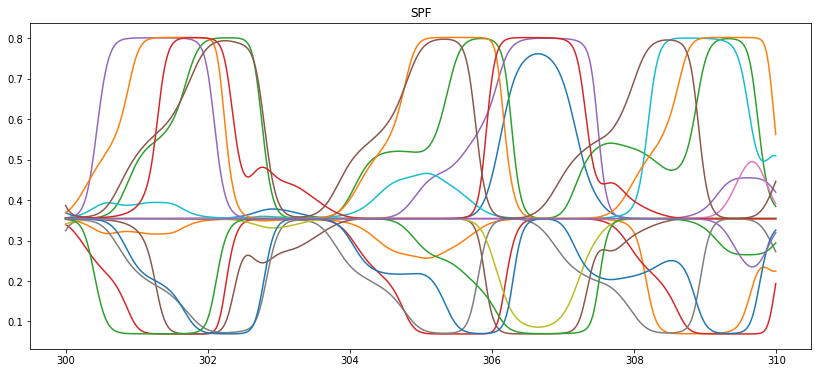

[0.35442897 0.22475252 0.38444719 0.19384574 0.4196011  0.35428971
 0.39101616 0.27254609 0.35425842 0.50957277 0.32590345 0.56259451
 0.29419398 0.35439768 0.31963595 0.44616555]


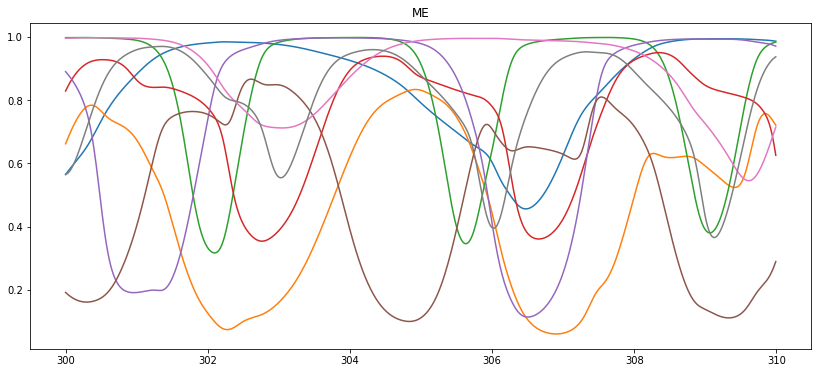

[0.98588095 0.72046433 0.98339603 0.62524262 0.97009391 0.28905266
 0.71401184 0.93667044]


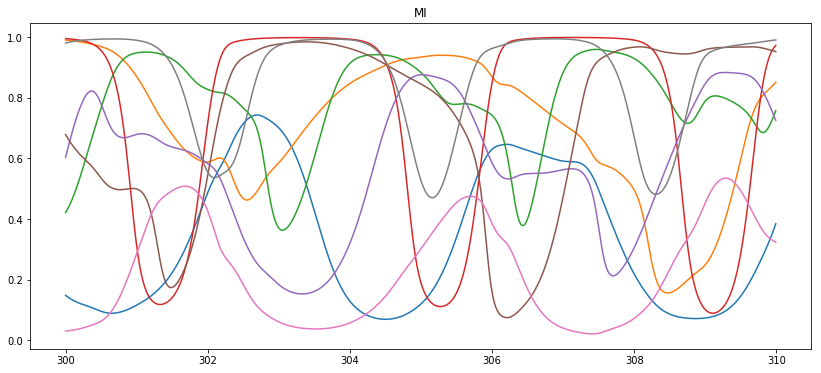

[0.38431325 0.85062408 0.757158   0.97230197 0.72512721 0.95207685
 0.32328053 0.99033315]


In [7]:
fs = (14,6)
# SPF
SPF_fig = plt.figure(figsize=fs)
SPF_data = np.array(data[SPF1+SPF2])
plt.plot(times, SPF_data.transpose())
plt.plot(times, np.sum(SPF_data, axis=0), linewidth=4)
plt.title('SPF')
plt.show()
print(SPF_data[:,-1])

# M
ME_fig = plt.figure(figsize=fs)
ME_data = np.array(data[ME])
plt.plot(times, ME_data.transpose())
plt.title('ME')
plt.show()
print(ME_data[:,-1])

MI_fig = plt.figure(figsize=fs)
MI_data = np.array(data[MI])
plt.plot(times, MI_data.transpose())
plt.title('MI')
plt.show()
print(MI_data[:,-1])


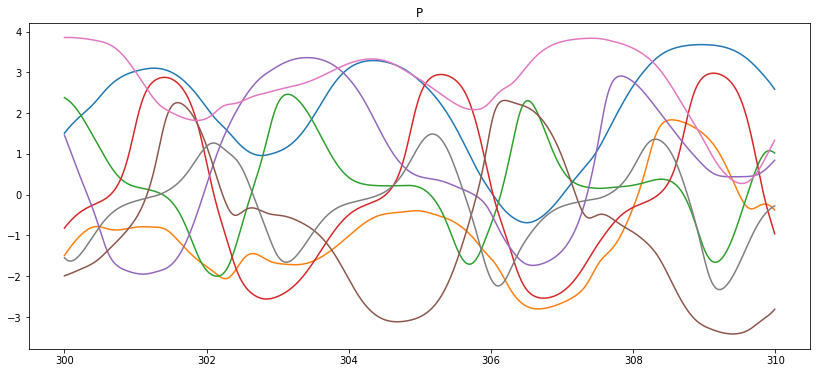

[ 2.58817337 -0.3751533   1.02143677 -0.95677499  0.84429947 -2.81254126
  1.33506419 -0.27331659]


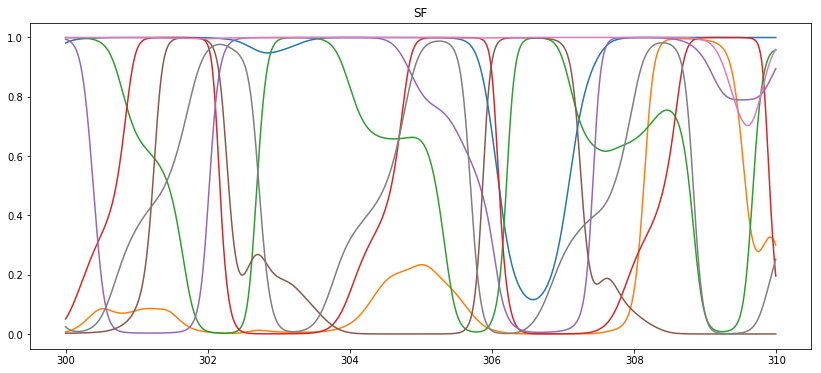

[9.99728501e-01 3.00187587e-01 9.57148866e-01 1.95412701e-01
 8.94880522e-01 1.53840668e-04 9.59891376e-01 2.52268379e-01]
[1. 0. 1. 0. 1. 0. 1. 0.]


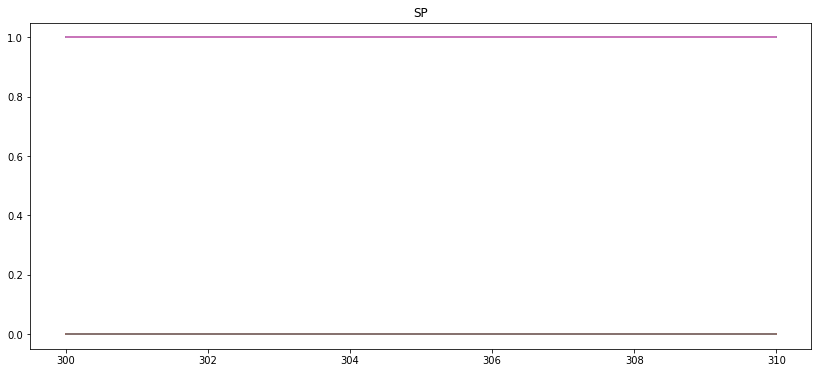

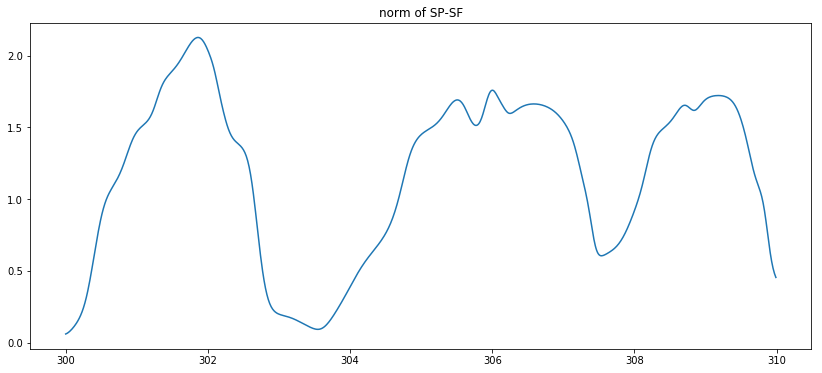

In [8]:
fs = (14,6)
# P
P_fig = plt.figure(figsize=fs)
P_data = np.array(data[P])
plt.plot(times, P_data.transpose())
plt.title('P')
plt.show()
print(P_data[:,-1])

# SF
SF_fig = plt.figure(figsize=fs)
SF_data = np.array(data[SF])
plt.plot(times, SF_data.transpose())
plt.title('SF')
plt.show()
print(SF_data[:,-1])

# SP
SP_fig = plt.figure(figsize=fs)
SP_data = np.array(data[SP])
plt.plot(times, SP_data.transpose())
plt.title('SP')
print(SP_data[:,-1])

# SP-SF
SP_SF = SP_data - SF_data
SP_SF_norm = np.linalg.norm(SP_SF, axis=0)
SP_SF_fig = plt.figure(figsize=fs)
plt.plot(times, SP_SF_norm)
plt.title('norm of SP-SF')
plt.show()


In [4]:
for idx, syn in enumerate(net.syns[ME[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in SPF1:
        pre_pop = 'SPF1'
    elif pre_id in SPF2:
        pre_pop = 'SPF2'
    elif pre_id in MI:
        pre_pop = 'MI'
    elif pre_id in ME:
        pre_pop = 'ME'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> ME, w=%f'%(idx, pre_pop, pre_id, syn.w))

0) SPF1 (16) --> ME, w=0.092370
1) SPF1 (17) --> ME, w=0.087687
2) SPF1 (18) --> ME, w=0.058198
3) SPF1 (19) --> ME, w=0.077286
4) SPF1 (20) --> ME, w=0.097122
5) SPF1 (21) --> ME, w=0.075212
6) SPF1 (22) --> ME, w=0.057860
7) SPF1 (23) --> ME, w=0.076689
8) SPF2 (24) --> ME, w=0.068081
9) SPF2 (25) --> ME, w=0.050364
10) SPF2 (26) --> ME, w=0.087509
11) SPF2 (27) --> ME, w=0.066616
12) SPF2 (28) --> ME, w=0.095496
13) SPF2 (29) --> ME, w=0.070467
14) SPF2 (30) --> ME, w=0.067395
15) SPF2 (31) --> ME, w=0.095108
16) ME (41) --> ME, w=0.053262
17) ME (42) --> ME, w=0.050225
18) ME (43) --> ME, w=0.042097
19) ME (44) --> ME, w=0.017977
20) ME (45) --> ME, w=0.010321
21) ME (46) --> ME, w=0.055381
22) ME (47) --> ME, w=0.014121
23) MI (48) --> ME, w=-0.099875
24) MI (49) --> ME, w=-0.098046
25) MI (50) --> ME, w=-0.100081
26) MI (51) --> ME, w=-0.100285
27) MI (52) --> ME, w=-0.091772
28) MI (53) --> ME, w=-0.092179
29) MI (54) --> ME, w=-0.083911
30) MI (55) --> ME, w=-0.089050


In [9]:
unit = net.units[ME[0]]
syns = unit.net.syns[unit.ID] 
pre_list_mp = []
for lst in unit.port_idx:
    pre_list_mp.append([syns[uid].preID for uid in lst])
print(pre_list_mp)
lists = []
lst1 = [[0,1], []]
for lst0 in lst1:
    lists.append([2*entry for entry in lst0])
[np.mean(l) if len(l) > 0. else 0. for l in lists]

[[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], [41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]]


[1.0, 0.0]

In [8]:
np.mean([])

/home/z/.local/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/z/.local/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [9]:
for idx, syn in enumerate(net.syns[MI[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in SPF1:
        pre_pop = 'SPF1'
    elif pre_id in SPF2:
        pre_pop = 'SPF2'
    elif pre_id in MI:
        pre_pop = 'MI'
    elif pre_id in ME:
        pre_pop = 'ME'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> MI, w=%f'%(idx, pre_pop, pre_id, syn.w))

0) SPF1 (16) --> MI, w=0.100525
1) SPF1 (17) --> MI, w=0.050542
2) SPF1 (18) --> MI, w=0.056261
3) SPF1 (19) --> MI, w=0.058378
4) SPF1 (20) --> MI, w=0.060990
5) SPF1 (21) --> MI, w=0.042274
6) SPF1 (22) --> MI, w=0.114571
7) SPF1 (23) --> MI, w=0.109524
8) SPF2 (24) --> MI, w=0.031845
9) SPF2 (25) --> MI, w=0.096852
10) SPF2 (26) --> MI, w=0.076916
11) SPF2 (27) --> MI, w=0.078567
12) SPF2 (28) --> MI, w=0.068375
13) SPF2 (29) --> MI, w=0.075989
14) SPF2 (30) --> MI, w=0.077922
15) SPF2 (31) --> MI, w=0.062901
16) MI (48) --> MI, w=-0.192743
17) MI (49) --> MI, w=-0.070590
18) MI (50) --> MI, w=-0.105846
19) MI (51) --> MI, w=-0.170218
20) MI (52) --> MI, w=0.000000
21) MI (53) --> MI, w=-0.013600
22) MI (54) --> MI, w=-0.029767
23) MI (55) --> MI, w=-0.110509
24) ME (40) --> MI, w=-0.150000
25) ME (41) --> MI, w=-0.150000
26) ME (42) --> MI, w=-0.150000
27) ME (43) --> MI, w=-0.150000
28) ME (44) --> MI, w=-0.150000
29) ME (45) --> MI, w=-0.150000
30) ME (46) --> MI, w=-0.150000
31)

In [5]:
print(net.units[0].buffer[:,-1])
print(net.units[1].buffer[:,-1])

[-4.97440801e-02  2.20763682e-01  1.00000000e+02  5.34213278e-01]
[  0.24246048   0.51299787 100.           0.53421344]


In [24]:
1. + 0.6068*np.sin(50.)

0.840790938772456